## Sources:
https://github.com/maxbozza/HOG-SVMlight-trainer/blob/master/train_SVMlight.py

https://github.com/aarcosg/object-detector-svm-hog-python


2-) 

* İlk ödevde ‘images/jpg/building.tif’ görüntüsü ile geliştirdiğiniz ölçek uzayı üzerinde 
yerel maksimum/yerel minimum noktaları belirlenecektir. 

* Ölçek uzayı olarak DoG filtreleme neticesinde ürettiğiniz 7 görüntüyü kullanabilirsiniz. 

* Yerel maksimum noktaları her bir pikselin 26-komşuluğu (9 komşu bir önceki ölçek, 8 komşu mevcut ölçek, 9 komşu bir sonraki ölçek için) kontrol edilerek belirlenecektir. 

* Yerel minimum için ise yerel maksimum bulmada kullandığınız sürecin aynısını ölçek uzayının işaretini tersine çevirerek çalıştırınız. 

* Elde ettiğiniz yerel maksimum ve minimum noktalarının tam sayı değerleri üzerinde uygun bir eşik değeri kullanınız (0,005 gibi küçük bir değer olabilir veya noktaların tamsayı değerlerine göre belirlenmiş bir değer olabilir, örneğin 0,05 * en büyük tamsayı değeri gibi). 

* Son olarak belirlediğiniz yerel noktaların kenar olma olasılığı yüksek olanlarını temizlemek için Hessian matrisine bağlı aşağıdaki koşulu kullanınız. 

0 ≤ 𝑡𝑟(𝐻𝜎)2 / det(𝐻𝜎) ≤ 12
𝑘𝑖 𝑏𝑢𝑟𝑎𝑑𝑎 𝐻𝜎 =[𝐿𝜎𝑥𝑥 𝐿𝜎𝑥𝑦 𝐿𝜎𝑦𝑥 𝐿𝜎𝑦𝑦] 𝑣𝑒 𝐿𝜎𝑥𝑥 =𝜕2(𝐿𝜎) / 𝜕𝑥2

* Elde ettiğiniz ilgi noktalarını ‘building.tif’ görüntüsü üzerinde genişletme ile gösteriniz. 

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from utils import img_read, show_img, show_hist

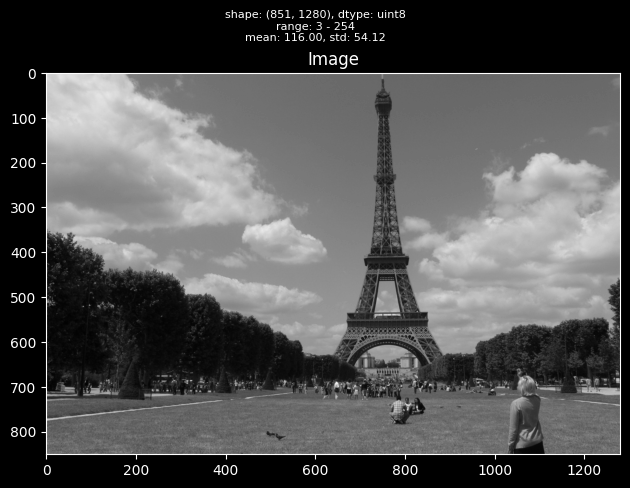

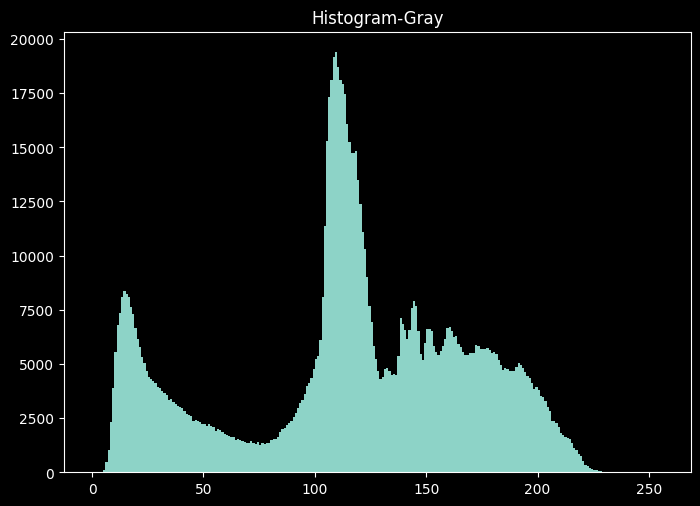

In [2]:
from utils import img_read
img = img_read('../images/jpg/eiffel2-1.jpg', ret_gray=True, show=False)
show_hist(img, channel_order="RGB", cumulative=False, bins=256)


sigma: 1.5


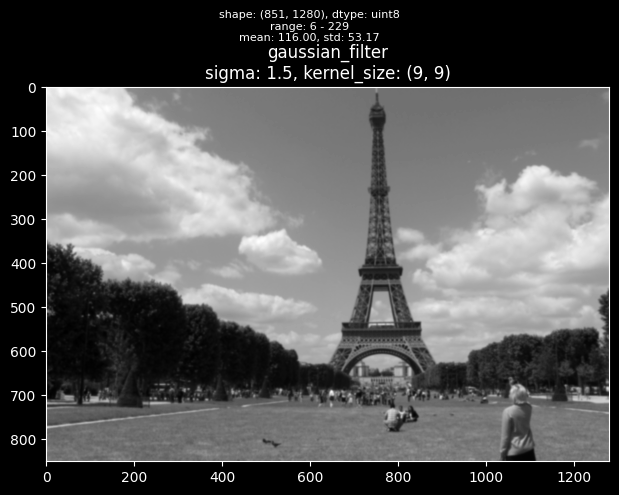


sigma: 3.0


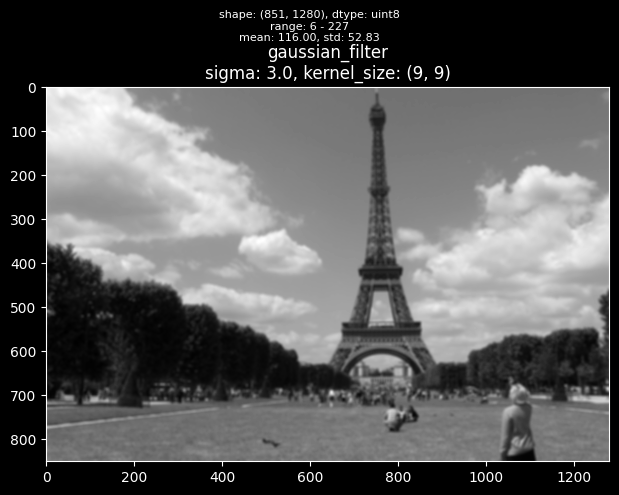


sigma: 4.5


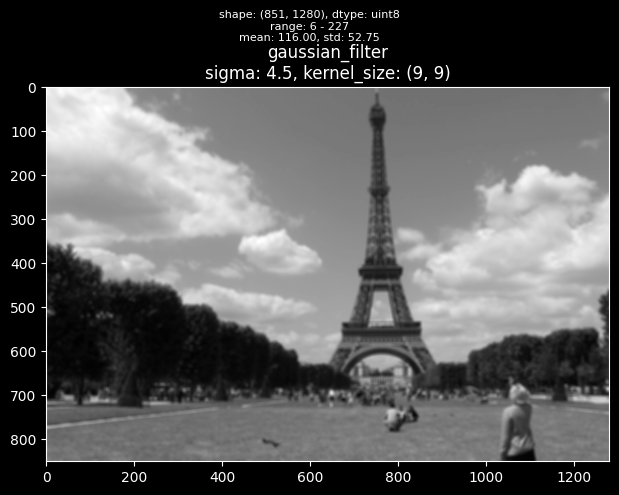


sigma: 6.0


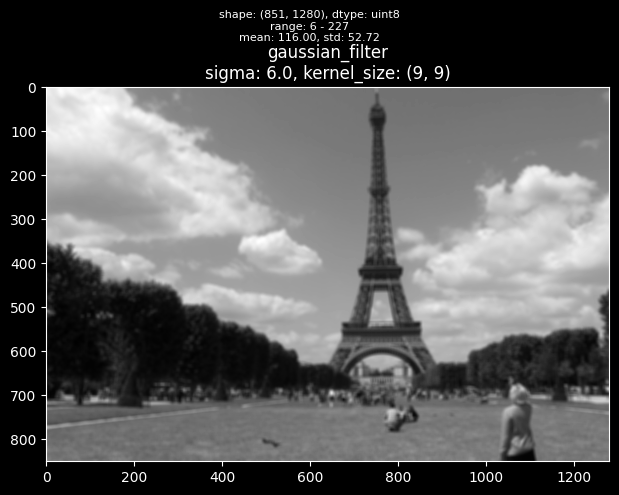


sigma: 7.5


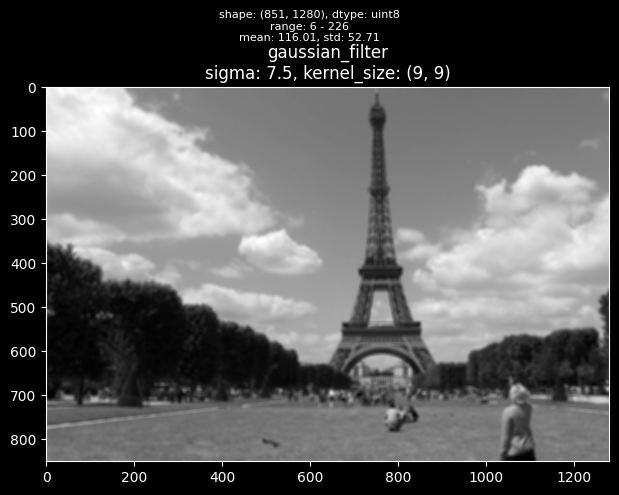


sigma: 9.0


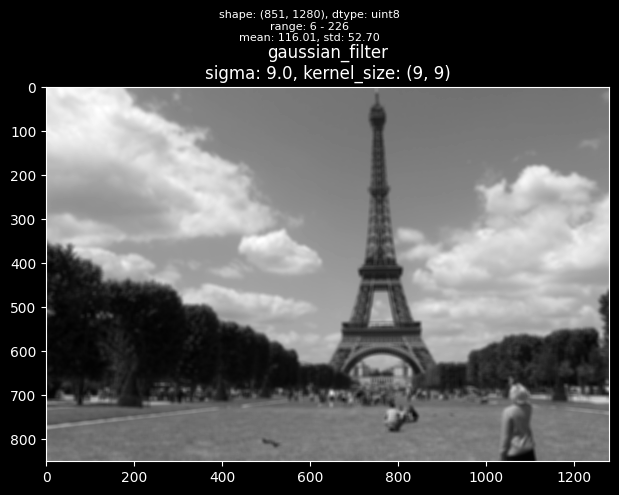


sigma: 10.5


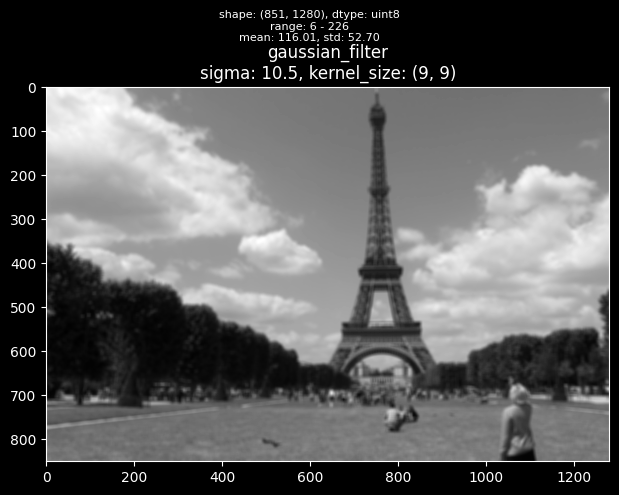

In [3]:
def gaussian_filter(img, kernel_size=5, sigma=0):
    kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
    kernel_size = (kernel_size[0] if kernel_size[0]%2 != 0 else kernel_size[0]+1, 
                    kernel_size[1] if kernel_size[1]%2 != 0 else kernel_size[1]+1)
    print()
    print("sigma:", sigma)
    # apply gaussian filter
    # https://docs.opencv.org/4.5.2/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1
    img_blur = cv2.GaussianBlur(img, ksize=kernel_size, sigmaX=sigma)
    #show_img(img_blur, title=f"gaussian_filter\nsigma: {sigma}, kernel_size: {kernel_size}", cmap="gray")
    return img_blur

gauss_imgs = []
sigmas = [i * 1.5 for i in range(1,8)]
for sigma in sigmas:
    img_blur = gaussian_filter(img=img, kernel_size=9, sigma=sigma)
    gauss_imgs.append(img_blur)

C:\Users\XTI\AppData\Local\Temp\ipykernel_7852\2598921577.py:11: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(scale_space, threshold_rel=threshold, min_distance=1, indices=True)
C:\Users\XTI\AppData\Local\Temp\ipykernel_7852\2598921577.py:14: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_min = peak_local_max(scale_space, threshold_rel=threshold, min_distance=1, indices=True)


(851, 1280, 3)
hessian_th:  0.006007547232156899
np.concatenate((local_max, local_min)).shape (45099, 2)
final points_of_interest .shape: 
 (1146, 2)


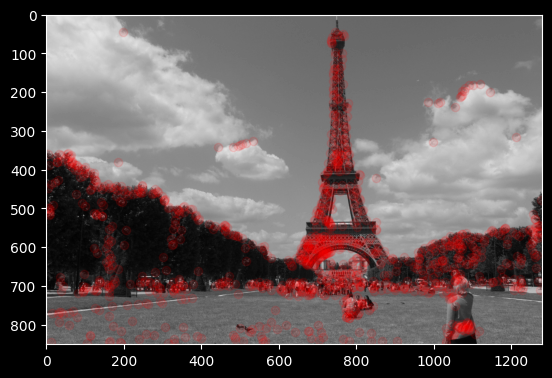

In [24]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import numpy as np
from skimage.feature import peak_local_max
from skimage.filters import difference_of_gaussians


def find_poi(image, sigma_min, sigma_max, threshold):
    # Create the scale space by applying DoG filtering
    scale_space = difference_of_gaussians(image, sigma_min, sigma_max)
    # Find local maxima
    local_max = peak_local_max(scale_space, threshold_rel=threshold, min_distance=1, indices=True)
    # Find local minima by reversing the sign of the scale space
    scale_space = -scale_space
    local_min = peak_local_max(scale_space, threshold_rel=threshold, min_distance=1, indices=True)

    hessian = np.transpose(np.array(hessian_matrix(image, sigma=sigma_max, order='rc')), (1,2,0))
    hessian_th = hessian.max() * threshold
    print(hessian.shape)
    print("hessian_th: ", hessian_th)

    # Use the Hessian matrix to clean up the points
    final_points = []
    """
    for point in np.concatenate((local_max, local_min)):
        eig_val, eig_vec = np.linalg.eig(hessian[point[0]][point[1]])
        if eig_val[0] < threshold and eig_val[1] < threshold:
            continue
        # Append to the points of interest
        points_of_interest.append(point)
    """

    print("np.concatenate((local_max, local_min)).shape", np.concatenate((local_max, local_min)).shape)
    for point in np.concatenate((local_max, local_min)):
        if (hessian[point[0]][point[1]] > hessian_th).all():
            final_points.append(point)

    final_points = np.array(final_points)
    print("final points_of_interest .shape: \n", final_points.shape)

    return final_points


# Call the find_poi function
points_of_interest = find_poi(img, sigma_min=0.5, sigma_max=1, threshold=0.05)

# Plot the image
plt.imshow(img, cmap='gray')
# Plot the points of interest on top of the image
plt.plot(points_of_interest[:, 1], points_of_interest[:, 0], 'ro', alpha=0.1)

plt.show()